In [1]:
# #from SHEAP.fitting.functions import linear,GaussianSum,linear2,combine_auto
# from SHEAP.fitting.functions import GaussianSum
# from SHEAP.main_sheap import Sheapectral 
# from SHEAP.spectra_readers import parallel_reader 
# from SHEAP.complex_region.region import ComplexRegion
# from SHEAP.ploting import *
# from SHEAP.host_sub.start_method import Extract_host_star
# from SHEAP.tools.others import wl_to_kms
# from SHEAP.fe_handler import fe_template_read,galaxy_template_read
# from SHEAP.complex_region.building_region import RegionBuilder
# from SHEAP.complex_region.fit_fe import fe_template_read

In [329]:
from sheap.spectra_readers import parallel_reader 
from sheap.MainSheap import Sheapectral 
from sheap.RegionHandler.RegionBuilder import RegionBuilder
from sheap.RegionHandler.RegionFitting import RegionFitting
from sheap.Plotting.SheapPlot import SheapPlot


In [330]:
import jax 
from jax import jit 
import jax.numpy as jnp
import glob 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
from paths_func import cross_pandas_spectra
jax.config.update("jax_enable_x64", True)

In [331]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [332]:
path_dr16 = "/home/favila/smbh_mass/dr16"
#path_dr16 = "/home/felipe/work/SMBH_estimation/dr16"

In [333]:
#dr16/subsample_07_03_25.csv

In [370]:
#file_paths,objs_panda  = cross_pandas_spectra(path_dr16,"bernal_sdss_fits","Objects_low_stellar_mass_with_stellar_contribution.csv")
file_paths,objs_panda = cross_pandas_spectra(path_dr16,"new_sub_sample_sdss_fits","subsample_07_03_25.csv")
objs_panda_sort = objs_panda.sort_values("SN_MEDIAN_ALL",ascending=False)[:1500][:500]
objs_panda_sort = objs_panda_sort.reset_index(drop=True)

You cross match found 11538


In [371]:
from astropy.io import fits 

In [372]:
aja = fits.open('/home/favila/smbh_mass/dr16/new_sub_sample_sdss_fits/2022-53827-0553.fits')

In [373]:
objs_panda_sort[objs_panda_sort.SDSS_NAME == "124813.82+362423.6"].fit_path.values

array(['/home/favila/smbh_mass/dr16/new_sub_sample_sdss_fits/2022-53827-0553.fits'],
      dtype=object)

In [374]:
coords,spectra_reshaped,_ = parallel_reader(objs_panda_sort.fit_path.values)
coords = jnp.array(coords)
spectra_reshaped = jnp.array(spectra_reshaped)

/home/favila/smbh_mass/sheap/sheap/spectra_readers.py:14: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (float(hdul[0].header["BUNIT"].split(" ")[0]) / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]*float(hdul[0].header["BUNIT"].split(" ")[0])) for key in ["loglam", "flux", "ivar"]])
/home/favila/smbh_mass/sheap/sheap/spectra_readers.py:14: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (float(hdul[0].header["BUNIT"].split(" ")[0]) / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]*float(hdul[0].header["BUNIT"].split(" ")[0])) for key in ["loglam", "flux", "ivar"]])
/home/favila/smbh_mass/sheap/sheap/spectra_readers.py:14: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (float(hdul[0].header["BUNIT"].split(" ")[0]) / np.sqrt(hdul[1].data[key]) i

In [375]:
test_clase = Sheapectral(spectra_reshaped,z=objs_panda_sort["Z_DR16Q"].values,coords = coords)
z_s=test_clase.z
#norm_factor=10**test_clase.spectra_exp
exp_factor = test_clase.spectra_exp
Spectra = test_clase.spectra

In [376]:
test_clase.spectra_exp

Array([15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       16., 15., 15., 15., 15., 15., 15., 16., 16., 15., 15., 15., 16.,
       15., 15., 15., 15., 15., 16., 16., 15., 15., 15., 16., 16., 15.,
       15., 16., 16., 15., 16., 15., 15., 15., 15., 15., 16., 15., 15.,
       15., 16., 16., 16., 16., 16., 15., 16., 16., 15., 16., 16., 16.,
       16., 15., 15., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       15., 16., 15., 15., 16., 15., 16., 16., 16., 16., 16., 15., 16.,
       16., 16., 16., 16., 15., 15., 15., 16., 16., 16., 16., 15., 16.,
       16., 15., 15., 15., 16., 15., 16., 16., 16., 16., 16., 15., 15.,
       16., 16., 16., 16., 16., 16., 16., 15., 16., 15., 15., 15., 15.,
       15., 16., 16., 16., 16., 16., 15., 16., 16., 15., 16., 16., 15.,
       16., 16., 16., 16., 15., 16., 15., 16., 16., 15., 16., 16., 16.,
       16., 15., 16., 16., 16., 16., 16., 16., 16., 15., 16., 15., 16.,
       15., 16., 16., 16., 15., 15., 16., 16., 16., 16., 16., 16

In [543]:
region = RegionBuilder(5600, 7500)
region.make_region(verbose=True,Fe_regions=['Fe_uv',"FeII_IZw1","feII_forbidden","FeII_coronal"],force_linear=True
                   ,n_broad = 2,n_narrow =1,narrow_plus=False,add_out_flow=True,tied_narrow_to="NIIa",template_mode_Fe=False)
Hbeta_class = RegionFitting(region.to_complex(add_free=True))

We assume a local linear continuum


In [538]:
#'Fe_uv',"FeII_IZw1","feII_forbidden","FeII_coronal"

In [539]:
region_panda = Hbeta_class.panda_region

In [540]:
region_panda

,center,line_name,kind,component,profile,amplitude,how
0,5890.0000,NaIa,broad,1,guassian,1.0,NaN
1,5890.0000,NaIa,broad,2,guassian,0.5,NaN
2,5896.0000,NaI1a,broad,1,guassian,1.0,NaN
3,5896.0000,NaI1a,broad,2,guassian,0.5,NaN
4,6046.4400,OIa,broad,1,guassian,1.0,NaN
5,6046.4400,OIa,broad,2,guassian,0.5,NaN
6,7002.2300,OIb,broad,1,guassian,1.0,NaN
7,7002.2300,OIb,broad,2,guassian,0.5,NaN
8,7254.4480,OIc,broad,1,guassian,1.0,NaN
9,7254.4480,OIc,broad,2,guassian,0.5,NaN


In [541]:
# dict_region = {"inner_limits":[4500, 5020],"outer_limits":[4400, 5600],"region":[{'how': 'template', 'line_name': 'Fe', 'which': 'OP', 'kind': 'Fe', 'component': 1, 'profile': 'guassian', 'amplitude': 1.0, 'center': 0.0}]}

- template with 1000 as initial it is ok 
- gaussian sum?

In [544]:
#Hbeta_class = RegionFitting("Halpha")
Hbeta_class(Spectra,exp_factor=exp_factor,num_steps=1000,re_normalize=True)

Runing: tied_params_step_1
learning_rate: 0.1
optimizer: adabelief
num_steps: 1000
Runing: tied_params_step_2
We assume a local linear continuum
learning_rate: 0.01
optimizer: adabelief
num_steps: 1000


In [526]:
Hbeta_class.tied_params

[['amplitude_Halpha_1_narrow', 'amplitude_NIIb_1_narrow', '*3.'],
 ['amplitude_NIIa_1_narrow', 'amplitude_NIIb_1_narrow', '*0.3'],
 ['center_SIIb_1_narrow', 'center_NIIb_1_narrow'],
 ['center_OIb_1_narrow', 'center_NIIb_1_narrow'],
 ['center_OIa_1_narrow', 'center_NIIb_1_narrow'],
 ['center_SIIa_1_narrow', 'center_NIIb_1_narrow'],
 ['center_NIIa_1_narrow', 'center_NIIb_1_narrow'],
 ['width_NIIa_1_narrow', 'width_NIIb_1_narrow'],
 ['width_SIIb_1_narrow', 'width_NIIb_1_narrow'],
 ['width_SIIa_1_narrow', 'width_NIIb_1_narrow'],
 ['width_OIa_1_narrow', 'width_NIIb_1_narrow'],
 ['width_OIb_1_narrow', 'width_NIIb_1_narrow']]

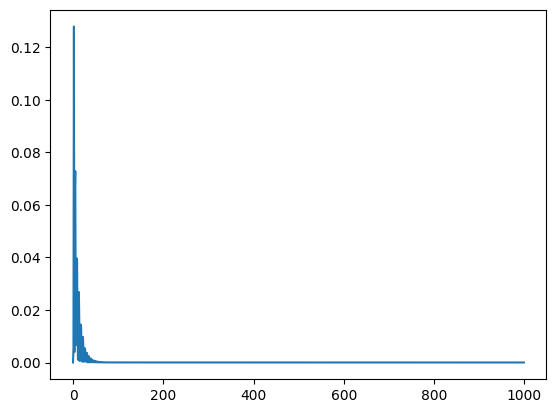

In [509]:
plt.plot(np.array(Hbeta_class.loss).T[0])

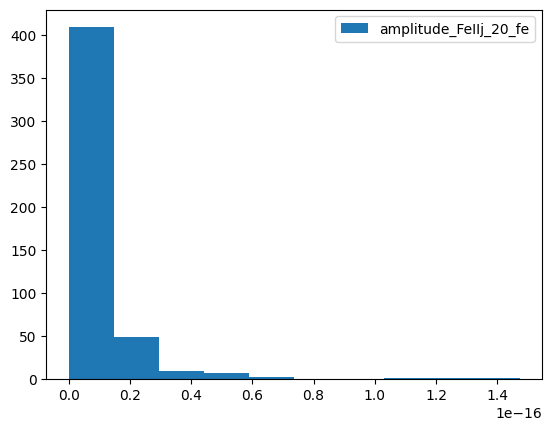

In [254]:
n_param = 27
plt.hist(Hbeta_class.params[:,n_param],label = list(Hbeta_class.params_dict.keys())[n_param] )
plt.legend()

In [255]:
# ii = pd.DataFrame(Hbeta_class.initial_params)

In [256]:
region_panda[region_panda["kind"]=="Fe"]

,center,line_name,kind,component,amplitude,how,profile


In [532]:
cc = pd.DataFrame(Hbeta_class.params,columns= list(Hbeta_class.params_dict.keys()))
cc[[c for c in cc.columns.values if "Halpha" in c]]

AttributeError: 'RegionFitting' object has no attribute 'params'

In [536]:
Hbeta_class.panda_params.iloc[10]

amplitude_NaIa_1_broad      0.000000e+00
center_NaIa_1_broad         5.894768e+03
width_NaIa_1_broad          3.391294e+01
amplitude_NaI1a_1_broad     0.000000e+00
center_NaI1a_1_broad        5.900931e+03
                                ...     
amplitude_Halpha_1_broad    5.858309e-15
center_Halpha_1_broad       6.569494e+03
width_Halpha_1_broad        3.589503e+01
m_cont                     -2.046666e-16
b_cont                      2.568508e-15
Name: 10, Length: 116, dtype: float64

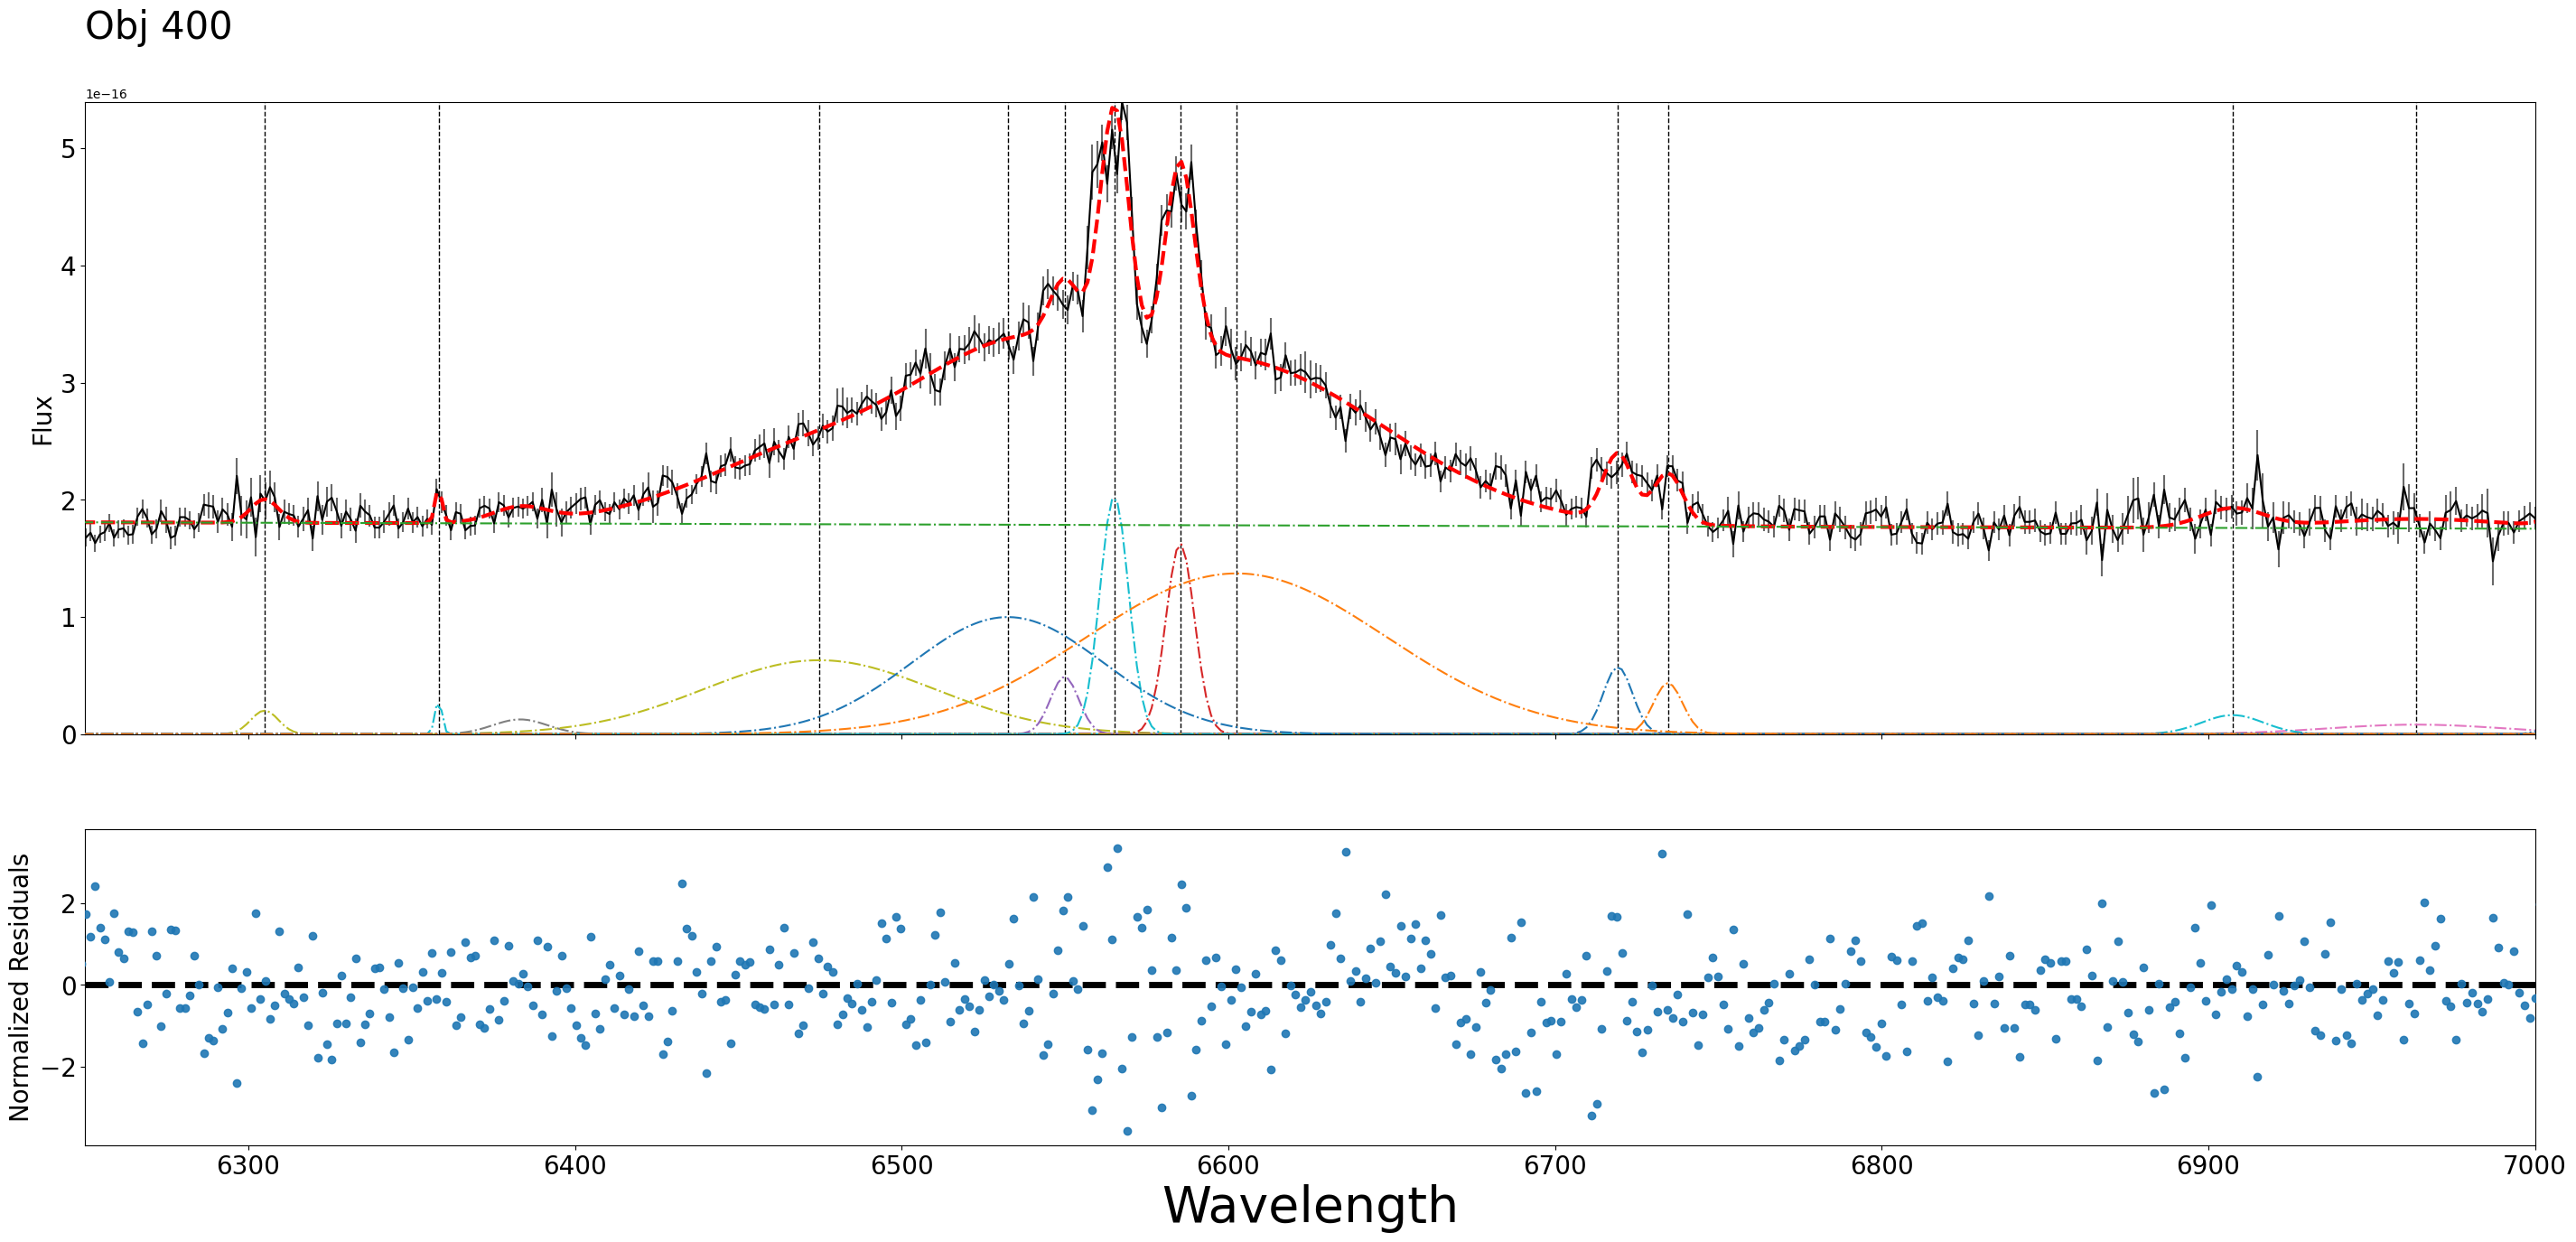

In [553]:
n = 400
region_plot = SheapPlot(Hbeta_class)
region_plot.plot(n,xlim=[6250, 7000])#207

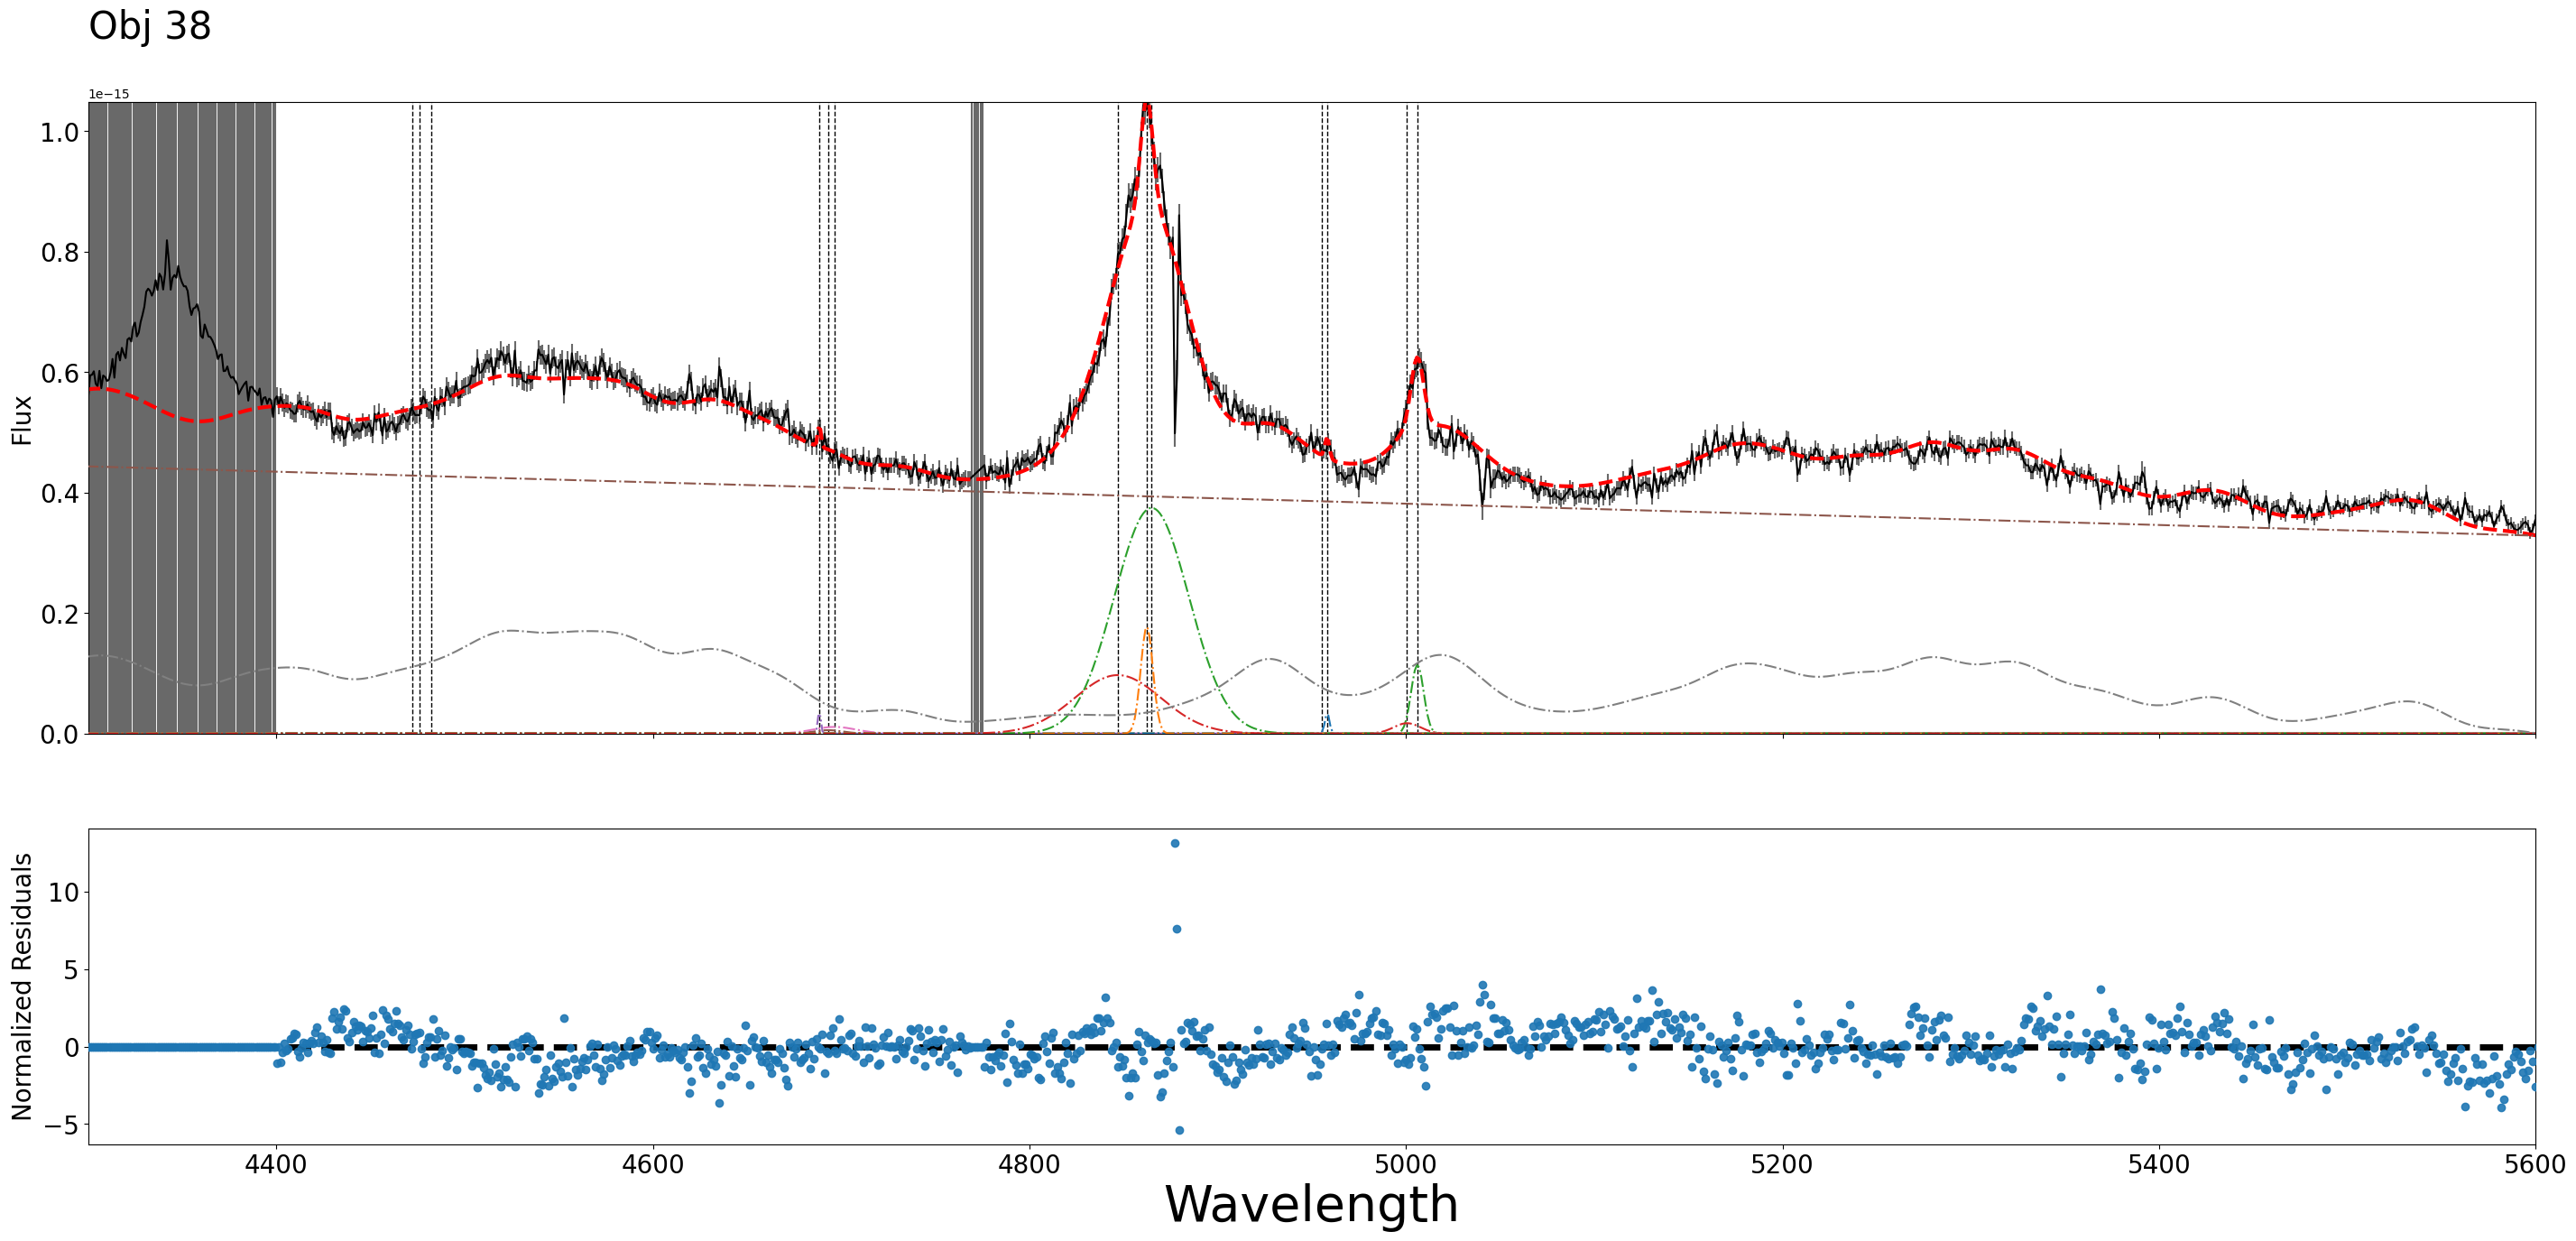

In [445]:
n = 38
region_plot = SheapPlot(Hbeta_class)
region_plot.plot(n,xlim=[4300, 5600])#207
#objs_panda_sort.iloc[n]

In [50]:
from astropy.io import fits

In [51]:
file_ = fits.open(objs_panda.iloc[n].fit_path)

(2500.0, 4000.0)

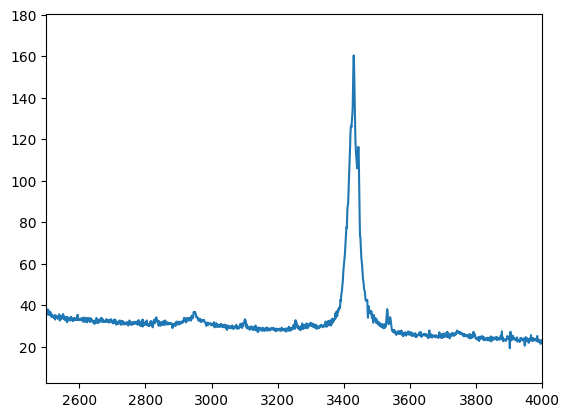

In [65]:
plt.plot(file_[1].data['flux'])
plt.xlim(2500,4000)

In [33]:
objs_panda[objs_panda["SDSS_NAME"]== "132059.42+295728.1"]

,SDSS_NAME,Z_DR16Q,FHOST_5100,Z_FIT,PLATE,MJD,FIBERID,RA,DEC,EBV,IF_BOSS_SDSS,SN_MEDIAN_ALL,LOGL5100,dr_name,fit_path
400,132059.42+295728.1,0.206057,0.0,0.206057,11401,58491,331,200.247599,29.957813,0.011451,BOSS,37.6791,44.424525,11401-58491-0331,/home/favila/smbh_mass/dr16/new_sub_sample_sds...
